In [1]:

import subprocess
import textwrap
from datetime import datetime
import pandas as pd

MODEL_NAME = "llama3.2:1b"   # change if you use another model
RESULTS = []                 # we’ll store all experiments here


In [3]:
import subprocess
import textwrap
import os
import time
import socket

# --- Ollama Installation and Server Startup ---

# Check if ollama is already installed by trying to run a simple command
try:
    subprocess.run(["ollama", "--version"], check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print("Ollama is already installed.")
except FileNotFoundError:
    print("Installing Ollama...")
    # Install ollama using its official script
    # The 'shell=True' is used here because of the pipe in the command.
    subprocess.run("curl -fsSL https://ollama.com/install.sh | sh", shell=True, check=True)
    print("Ollama installation complete.")

# Check if Ollama server is running by trying to connect to its default port (11434)
def is_ollama_server_up():
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    try:
        s.connect(('127.0.0.1', 11434))
        s.close()
        return True
    except (ConnectionRefusedError, socket.timeout):
        return False
    except Exception as e:
        print(f"Error checking Ollama server status: {e}")
        return False

if not is_ollama_server_up():
    print("Starting Ollama server...")
    # Start ollama server in background, redirecting output to a log file
    # Use `setsid` to ensure it truly detaches and isn't killed if the parent process exits.
    server_command = "setsid nohup ollama serve > ollama_server.log 2>&1 &"
    subprocess.Popen(server_command, shell=True)
    # Give the server a moment to start up
    time.sleep(10) # Adjust sleep time if necessary
    if is_ollama_server_up():
        print("Ollama server started successfully.")
    else:
        print("Failed to start Ollama server or it's still starting.")
else:
    print("Ollama server is already running.")

# --- End Ollama Setup ---


def run_ollama(prompt: str, model: str = MODEL_NAME) -> str:
    """
    Call the Ollama CLI with a given prompt and return the model's text output.
    This assumes `ollama` works from your system PATH and the server is running.
    """
    try:
        # Check if the model is available locally and pull if necessary.
        # This prevents `ollama run` from hanging on download.
        list_models_output = subprocess.run(
            ["ollama", "list"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            check=True
        ).stdout.decode("utf-8")

        # Simple check: see if the model's base name is in the list output
        if model.split(':')[0] not in list_models_output:
            print(f"Model '{model}' not found locally. Pulling it now...")
            subprocess.run(
                ["ollama", "pull", model],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                check=True
            )
            print(f"Model '{model}' pulled successfully.")
        else:
            print(f"Model '{model}' is already available locally.")

        # Now, run the model with the given prompt
        completed = subprocess.run(
            ["ollama", "run", model],
            input=prompt.encode("utf-8"),
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            check=True # Raise CalledProcessError if the command returns a non-zero exit code
        )

        if completed.stderr:
            # Not raising an error here, just printing in case there are warnings or non-critical errors
            print("STDERR from ollama:\n", completed.stderr.decode("utf-8"))

        return completed.stdout.decode("utf-8")
    except subprocess.CalledProcessError as e:
        print(f"Error running Ollama command: {e}")
        print(f"STDOUT: {e.stdout.decode('utf-8')}")
        print(f"STDERR: {e.stderr.decode('utf-8')}")
        return f"Error: Failed to run Ollama for prompt: {prompt}. See logs for details."
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return f"Error: An unexpected issue occurred while interacting with Ollama."


# quick sanity check (you can comment this out later)
test_output = run_ollama("Say hello in one short sentence.")
print(test_output)


Installing Ollama...
Ollama installation complete.
Starting Ollama server...
Ollama server started successfully.
Model 'llama3.2:1b' not found locally. Pulling it now...
Model 'llama3.2:1b' pulled successfully.
STDERR from ollama:
 ⠙ ⠹ ⠹ ⠼ ⠼ ⠴ ⠦ ⠇ ⠇ ⠋ ⠋ ⠹ ⠸ ⠼ ⠼ ⠦ ⠦ ⠧ ⠏ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠦ ⠦ ⠧ ⠏ ⠏ ⠋ ⠙ ⠹ ⠼ ⠼ ⠦ ⠦ ⠇ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠴ ⠴ 
Hello.




In [5]:


sports_context = textwrap.dedent("""
    This document explains basic ideas in sports performance.
    It discusses the difference between endurance training and strength training,
    how athletes try to prevent injuries, and why nutrition and hydration matter.
    It also covers recovery methods such as rest, stretching, and ice baths,
    explains how overtraining can hurt performance, and highlights the role of
    teamwork and communication in team sports like soccer and basketball.
""").strip()

print(sports_context)

basic_questions = [
    "What is endurance training and why is it important for athletes?",
    "How do athletes reduce the risk of injuries during training and games?",
    "Why is nutrition important for athletes? Explain in simple words.",
    "How does teamwork and communication improve performance in team sports?",
    "What are some common recovery methods athletes use after intense workouts?"
]

for i, q in enumerate(basic_questions, start=1):
    prompt = f"""You are a helpful AI answering questions about sports.

Context:
{sports_context}

Question {i}: {q}
Answer in a short paragraph.
"""
    print("=" * 80)
    print(f"[STEP 1 – BASIC] Question {i}: {q}\n")

    response = run_ollama(prompt)

    print(response)

    RESULTS.append({
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "step": 1,
        "prompt_type": "basic",
        "question_id": i,
        "question": q,
        "prompt": prompt,
        "response": response,
        "correctness": None,
        "completeness": None,
        "clarity": None,
        "notes": ""
    })


This document explains basic ideas in sports performance. 
It discusses the difference between endurance training and strength training, 
how athletes try to prevent injuries, and why nutrition and hydration matter.
It also covers recovery methods such as rest, stretching, and ice baths,
explains how overtraining can hurt performance, and highlights the role of
teamwork and communication in team sports like soccer and basketball.
[STEP 1 – BASIC] Question 1: What is endurance training and why is it important for athletes?

Model 'llama3.2:1b' is already available locally.
STDERR from ollama:
 ⠙ ⠙ ⠸ ⠸ ⠼ ⠦ ⠧ ⠧ ⠇ ⠋ ⠋ ⠹ ⠸ ⠼ ⠴ ⠦ ⠦ ⠧ ⠏ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠧ ⠇ ⠇ ⠋ ⠋ ⠙ ⠸ ⠸ ⠼ ⠦ ⠦ ⠇ ⠇ ⠋ ⠋ ⠹ ⠹ ⠼ ⠼ ⠴ ⠦ ⠇ ⠇ ⠏ ⠙ ⠙ ⠸ ⠸ ⠴ ⠦ ⠦ ⠧ ⠏ ⠏ ⠋ ⠙ ⠸ ⠸ ⠼ ⠴ ⠦ ⠇ 
Endurance training refers to exercises that challenge an athlete's ability to sustain effort over a prolonged period, typically at or below their maximum intensity. This type of training is essential for athletes because it helps improve cardiovascular fitness, i

In [6]:
# --- Cell 5: Structured prompts (Step 2) ---

structured_prompts = [
    {
        "id": 1,
        "label": "training_table",
        "question": "Describe endurance training and strength training.",
        "prompt": f"""
You are an assistant summarizing sports training methods.

Context:
{sports_context}

Task:
Describe endurance training and strength training in a TABLE with three columns:
1) Training Type
2) Main Goal
3) Example Exercises

Return the table in plain text (Markdown style).
"""
    },
    {
        "id": 2,
        "label": "injury_bullets",
        "question": "How athletes prevent injuries.",
        "prompt": f"""
You are an assistant listing safety tips for athletes.

Context:
{sports_context}

Task:
List 5 bullet points that explain how athletes can prevent injuries
before and after games.
"""
    },
    {
        "id": 3,
        "label": "nutrition_json",
        "question": "Why nutrition matters for athletes.",
        "prompt": f"""
You are an assistant describing sports nutrition.

Context:
{sports_context}

Task:
Answer the question "Why is nutrition important for athletes?"
in VALID JSON with this structure:

{{
  "main_reason": "",
  "key_nutrients": ["", "", ""],
  "common_mistakes": ["", ""]
}}

Do not add extra fields or comments. Just return the JSON object.
"""
    },
    {
        "id": 4,
        "label": "teamwork_numbered",
        "question": "How teamwork helps a soccer team.",
        "prompt": f"""
You are an assistant explaining teamwork in soccer.

Context:
{sports_context}

Task:
Explain how teamwork and communication help a soccer team perform better.
Write the answer as a numbered list of 4–6 short points.
"""
    },
    {
        "id": 5,
        "label": "recovery_table",
        "question": "Compare rest, stretching, and ice baths.",
        "prompt": f"""
You are an assistant comparing recovery methods for athletes.

Context:
{sports_context}

Task:
Create a table comparing rest, stretching, and ice baths as recovery methods.
Use columns: Method, How it helps, When it is most useful.
Return the table as plain text (Markdown).
"""
    }
]

for item in structured_prompts:
    print("=" * 80)
    print(f"[STEP 2 – STRUCTURED] {item['label']} – {item['question']}\n")

    response = run_ollama(item["prompt"])

    print(response)

    RESULTS.append({
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "step": 2,
        "prompt_type": "structured",
        "question_id": item["id"],
        "question": item["question"],
        "prompt": item["prompt"],
        "response": response,
        "correctness": None,
        "completeness": None,
        "clarity": None,
        "notes": ""
    })


[STEP 2 – STRUCTURED] training_table – Describe endurance training and strength training.

Model 'llama3.2:1b' is already available locally.
STDERR from ollama:
 ⠙ ⠹ ⠸ ⠼ ⠼ ⠦ ⠦ ⠇ ⠇ ⠏ ⠋ ⠹ ⠹ ⠼ ⠴ ⠦ ⠧ ⠧ ⠏ ⠋ ⠙ ⠹ ⠹ ⠸ ⠼ ⠦ ⠧ ⠇ ⠏ ⠏ ⠙ ⠙ ⠹ ⠸ ⠼ ⠦ ⠦ ⠇ ⠇ ⠋ ⠋ ⠹ ⠹ ⠼ ⠼ ⠴ ⠧ ⠇ ⠇ ⠋ ⠙ ⠙ ⠸ ⠸ ⠼ ⠴ ⠧ ⠇ ⠇ ⠋ ⠙ ⠙ ⠹ ⠼ ⠼ ⠦ ⠧ ⠧ ⠏ ⠏ ⠋ ⠹ ⠹ ⠼ ⠼ 
Here is the table summarizing endurance training and strength training:

| **Training Type** | **Main Goal** | **Example Exercises** |
| --- | --- | --- |
| Endurance Training | Improve Cardiovascular Capacity | Running, Cycling, Swimming, High-Intensity Interval Training (HIIT) |
| Strength Training | Increase Muscular Endurance | Squats, Deadlifts, Bench Press, Pull-Ups, Lunges |

Note: These are just examples and not exhaustive lists. Both endurance training and strength training have many variations and applications across different sports and age groups.


[STEP 2 – STRUCTURED] injury_bullets – How athletes prevent injuries.

Model 'llama3.2:1b' is already available locally

In [7]:
# --- Cell 6: Few-shot prompts (Step 3) ---

few_shot_prompts = [
    {
        "id": 1,
        "label": "endurance_explanation",
        "question": "What is endurance training, and why is it important for athletes?",
        "prompt": f"""
You are answering questions about sports training in a clear and simple style.

Context:
{sports_context}

Example 1
Question: What is a warm-up in sports?
Answer: A warm-up is a short period of light activity before exercise or a game.
It slowly increases heart rate, warms up the muscles, and prepares the body to
move safely and quickly.

Example 2
Question: What is a cool-down in sports?
Answer: A cool-down is light movement and stretching after exercise.
It helps the body return to a resting state, reduces muscle stiffness, and can
lower the risk of soreness.

Now answer in the same style.

Question: What is endurance training, and why is it important for athletes?
Answer:"""
    },
    {
        "id": 2,
        "label": "recovery_definition_example",
        "question": "What is recovery in sports, and why is it important after a game?",
        "prompt": f"""
You answer questions about sports using this pattern:
1) A short definition in one sentence
2) One real-life example

Context:
{sports_context}

Example 1
Question: What is strength training?
Answer: Strength training is exercise that makes muscles stronger by using
resistance like weights or body weight. For example, a basketball player
might do squats and lunges in the gym to jump higher and be more powerful
on the court.

Example 2
Question: What is flexibility training?
Answer: Flexibility training focuses on stretching muscles and improving the
range of motion in joints. For example, a gymnast may stretch daily to move
more freely and perform complex routines without injury.

Now answer in the same style.

Question: What is recovery in sports, and why is it important after a game?
Answer:"""
    }
]

for item in few_shot_prompts:
    print("=" * 80)
    print(f"[STEP 3 – FEW-SHOT] {item['label']}\n")

    response = run_ollama(item["prompt"])

    print(response)

    RESULTS.append({
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "step": 3,
        "prompt_type": "few-shot",
        "question_id": item["id"],
        "question": item["question"],
        "prompt": item["prompt"],
        "response": response,
        "correctness": None,
        "completeness": None,
        "clarity": None,
        "notes": ""
    })


[STEP 3 – FEW-SHOT] endurance_explanation

Model 'llama3.2:1b' is already available locally.
STDERR from ollama:
 ⠋ ⠹ ⠹ ⠼ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠼ ⠴ ⠴ ⠧ ⠧ ⠇ ⠋ ⠙ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠇ ⠏ ⠏ ⠙ ⠙ ⠸ ⠸ ⠴ ⠴ ⠧ ⠧ ⠏ ⠏ ⠙ ⠙ ⠹ ⠸ ⠴ ⠦ ⠦ ⠧ ⠏ ⠋ ⠋ ⠹ ⠹ ⠸ ⠼ ⠦ ⠧ ⠧ ⠇ ⠏ ⠙ ⠙ ⠹ ⠼ ⠼ ⠦ ⠦ ⠧ ⠇ ⠏ ⠙ ⠙ ⠹ ⠸ ⠼ ⠦ ⠧ ⠧ ⠏ ⠏ ⠙ ⠹ ⠹ ⠼ ⠴ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠏ ⠙ ⠹ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠏ ⠏ ⠙ ⠹ ⠸ ⠸ ⠴ ⠴ ⠦ ⠇ 
Endurance training is an essential part of sports performance. It involves activities that challenge the body to use oxygen longer than any other type of exercise, such as distance running or cycling.

Why is endurance training important? Well, when you engage in high-intensity activities, your muscles and cardiovascular system work together to provide energy. To do this efficiently, they need to be highly trained and adapted over time. Endurance training helps build the stamina needed for prolonged periods of activity. It also improves blood flow and increases the efficiency with which oxygen is delivered to the muscles.

In endurance sport

In [8]:
# --- Cell 7: Chain-of-Thought prompts (Step 4) ---

cot_prompts = [
    {
        "id": 1,
        "label": "overtraining_effects",
        "question": "Why can overtraining hurt an athlete’s performance?",
        "prompt": f"""
You are a reasoning assistant.

Context:
{sports_context}

Question:
Why can overtraining hurt an athlete’s performance, even if they are training very hard?

Think step by step:
1. List the physical effects of overtraining.
2. List the mental effects of overtraining.
3. Explain how these effects lead to worse performance in games.
Finally, give a short summary answer in 2–3 sentences.
"""
    },
    {
        "id": 2,
        "label": "communication_in_team",
        "question": "How can poor communication reduce a soccer team's performance?",
        "prompt": f"""
You are a reasoning assistant.

Context:
{sports_context}

Scenario:
A soccer team has very skilled players, but they lose many games because they
do not communicate well on the field.

Question:
How can poor communication reduce the team’s performance, even if individual players are talented?

Reason step by step:
1. Identify several ways communication affects team play (positioning, passing, defending, etc.).
2. Explain each point with a short example.
3. End with a brief summary of why communication is critical.
"""
    },
    {
        "id": 3,
        "label": "marathon_vs_sprint_training",
        "question": "How should training differ for a marathon runner and a sprinter?",
        "prompt": f"""
You are helping a coach design training programs.

Context:
{sports_context}

Question:
How should training be different for a marathon runner and a sprinter?

Think step by step:
1. Describe the main demands of a marathon (distance, time, energy systems).
2. Describe the main demands of a sprint race.
3. Explain how these demands change the focus of training
   (endurance vs power, type of workouts, recovery).
4. Finish with a short comparison summary of the two training plans.
"""
    },
    {
        "id": 4,
        "label": "nutrition_decision",
        "question": "Why is a player's current eating pattern a problem?",
        "prompt": f"""
You are a reasoning assistant.

Context:
{sports_context}

Scenario:
A basketball player often feels tired in the second half of games.
They usually skip breakfast and eat a heavy meal right before playing.

Question:
Based on what you know about sports nutrition, why might this be a problem,
and what changes could help?

Think step by step:
1. Identify issues with their current eating pattern.
2. Connect those issues to energy levels and performance.
3. Suggest a better pre-game nutrition plan in simple steps.
"""
    }
]

for item in cot_prompts:
    print("=" * 80)
    print(f"[STEP 4 – CoT] {item['label']}\n")

    response = run_ollama(item["prompt"])

    print(response)

    RESULTS.append({
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "step": 4,
        "prompt_type": "chain-of-thought",
        "question_id": item["id"],
        "question": item["question"],
        "prompt": item["prompt"],
        "response": response,
        "correctness": None,
        "completeness": None,
        "clarity": None,
        "notes": ""
    })


[STEP 4 – CoT] overtraining_effects

Model 'llama3.2:1b' is already available locally.
STDERR from ollama:
 ⠋ ⠹ ⠹ ⠸ ⠴ ⠴ ⠦ ⠇ ⠏ ⠋ ⠋ ⠹ ⠸ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠙ ⠙ ⠸ ⠸ ⠴ ⠦ ⠧ ⠇ ⠇ ⠋ ⠙ ⠙ ⠸ ⠸ ⠴ ⠴ ⠧ ⠧ ⠏ ⠏ ⠙ ⠙ ⠸ ⠸ ⠴ ⠴ ⠧ ⠧ ⠏ ⠋ ⠙ ⠙ ⠸ ⠼ ⠴ ⠦ ⠧ ⠧ ⠏ ⠏ ⠙ ⠙ ⠸ ⠼ ⠼ ⠦ ⠦ ⠧ ⠏ ⠏ ⠙ ⠹ ⠹ ⠼ ⠼ ⠦ ⠦ ⠇ ⠇ ⠋ ⠋ 
To address your question, here's a step-by-step analysis:

1. Physical Effects of Overtraining:
- Fatigue: Athletes feel exhausted and tired, which can impair their ability to perform at a high level.
- Decreased Muscle Mass: Prolonged overtraining leads to muscle atrophy as the body's energy stores are depleted and muscles begin to break down for recovery.
- Insulin Resistance: Overtraining causes blood sugar levels to drop, leading to insulin resistance, which can affect athletic performance.

2. Mental Effects of Overtraining:
- Anxiety and Stress: Athletes may experience high levels of stress, anxiety, or worry about their performance, affecting their mental well-being and decision-making abilities.
- Decreased Moti

In [9]:


df = pd.DataFrame(RESULTS)
df.head()


df.to_csv("ollama_sports_prompt_lab_results.csv", index=False)
print("Saved results to ollama_sports_prompt_lab_results.csv")



Saved results to ollama_sports_prompt_lab_results.csv


In [25]:
# Add scoring columns and export a CSV for manual rating
df_scores = df.copy()
for col in ["correctness_0_5", "completeness_0_5", "clarity_0_5", "notes"]:
    if col not in df_scores.columns:
        df_scores[col] = ""

out_csv = os.path.join(RESULTS_DIR, "ollama_sports_prompt_lab_results.csv")
df_scores.to_csv(out_csv, index=False)
out_csv

'/content/prompt_lab_results/ollama_sports_prompt_lab_results.csv'

In [27]:
import pandas as pd, numpy as np

ratings_path = os.path.join(RESULTS_DIR, "ollama_sports_prompt_lab_results.csv")
ratings = pd.read_csv(ratings_path)

def to_num(x):
    try:
        return float(x)
    except:
        return np.nan

ratings["correctness_0_5"] = ratings["correctness_0_5"].apply(to_num)
ratings["completeness_0_5"] = ratings["completeness_0_5"].apply(to_num)
ratings["clarity_0_5"] = ratings["clarity_0_5"].apply(to_num)

summary = ratings.groupby("step")[["correctness_0_5","completeness_0_5","clarity_0_5"]].mean().round(2)
summary

,correctness_0_5,completeness_0_5,clarity_0_5
Basic,4.8,5.0,5.0
CoT_fewshot,4.0,4.2,4.0
Few-shot,5.0,4.8,5.0
Structured,3.7,2.8,3.0


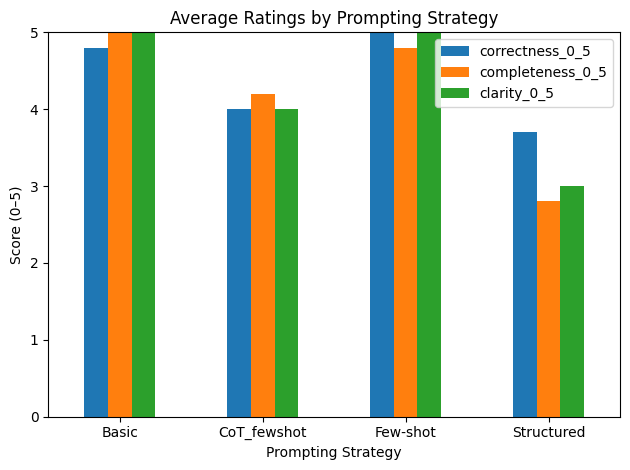

In [24]:


import matplotlib.pyplot as plt

ax = summary.plot(kind="bar")
plt.title("Average Ratings by Prompting Strategy")
plt.ylabel("Score (0–5)")
plt.xlabel("Prompting Strategy")
plt.xticks(rotation=0)
plt.ylim(0, 5)
plt.tight_layout()
plt.show()
